In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from collections import defaultdict
from tqdm import tqdm
from pathlib import Path
import networkx as nx

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Paths and Constants
SCRIPT_DIR = Path.cwd()
DATA_FOLDER = SCRIPT_DIR / "data"
MODEL_FOLDER = SCRIPT_DIR / "models"
DATA_FOLDER.mkdir(parents=True, exist_ok=True)
MODEL_FOLDER.mkdir(parents=True, exist_ok=True)

TIME_STAMP = 1738439134000
KLINE_INTERVAL = "30m"
SYMBOL = "BTCUSDT"

PARQUET_PATH = str(DATA_FOLDER / f"{TIME_STAMP}/{KLINE_INTERVAL}/{SYMBOL}.parquet")

## Importing Required Libraries and Configuring Environment

### Overview
In this section, we import the necessary libraries and set up essential configurations for the trading backtesting environment. This includes data handling, logging, and directory management.

### Libraries Used:
- **pandas**: For data manipulation and reading Parquet files.
- **numpy**: Provides numerical operations, including calculations on arrays.
- **matplotlib & seaborn**: For visualizing trading performance and market trends.
- **logging**: Enables structured logging for debugging and tracking program execution.
- **defaultdict (collections)**: Helps manage transition matrices for the Markov model.
- **tqdm**: Provides a progress bar for long-running processes.
- **pathlib**: Simplifies file path handling across different operating systems.
- **networkx**: Used for graph-based visualization of state transitions in the Markov chain.

### Configuration:
- **Logging Setup**: The logging module is configured to provide timestamps and log messages, making debugging and execution tracking easier.
- **Directory Management**:
  - `DATA_FOLDER` stores input data.
  - `MODEL_FOLDER` is created for potential model saving.
- **File Path Construction**:
  - The script constructs the **path to a Parquet file** containing historical market data.
  - The naming convention ensures that different timestamps and intervals can be handled dynamically.

These configurations set the stage for the core data processing and trading simulation sections.

---


In [16]:
# Load CSV Data with validation
def load_data(file_path):
    if not Path(file_path).exists():
        logging.error("Data file does not exist: %s", file_path)
        return None
    df = pd.read_parquet(file_path)
    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df = df.sort_values(by='Open Time')
    return df.dropna()

## Loading Market Data with Validation

### Overview
This function, `load_data(file_path)`, is responsible for loading market data from a Parquet file while ensuring data integrity through validation and preprocessing.

### Function Breakdown:
1. **File Existence Check**:
   - The function first checks if the specified file path exists.
   - If the file is missing, an error is logged, and `None` is returned.
   - This prevents the script from crashing due to missing data.

2. **Reading the Parquet File**:
   - The **pandas** function `pd.read_parquet(file_path)` is used to read the dataset.
   - Parquet format is chosen over CSV for its **efficient storage and faster reading speed**.

3. **Time Conversion**:
   - The column **'Open Time'** is converted from a timestamp (milliseconds since epoch) to a human-readable datetime format using:
     \[
     \text{{df['Open Time']}} = \text{{pd.to_datetime(df['Open Time'], unit='ms')}}
     \]
   - This enables easier time-based analysis and visualization.

4. **Sorting Data Chronologically**:
   - The dataset is sorted by **'Open Time'** to ensure that historical price data is processed in the correct order.

5. **Handling Missing Data**:
   - The function removes **NaN (missing)** values using `df.dropna()`.
   - This step ensures that missing or corrupted entries do not affect calculations.

### Why is this Important?
- **Ensures Data Integrity**: By validating file existence and removing missing values.
- **Optimized Performance**: Parquet format improves loading efficiency.
- **Prepares for Time-Series Analysis**: Converting timestamps and sorting ensures correct order for modeling.

---


In [17]:
# Compute velocity with optimized rolling window
def compute_velocity(df):
    df['velocity'] = df['Close'].pct_change().rolling(window=3, min_periods=1).mean()
    return df

# Assign states based on velocity thresholds
def assign_state(df):
    high_threshold = df['velocity'].quantile(0.75)
    low_threshold = df['velocity'].quantile(0.25)
    
    conditions = [
        df['velocity'] > high_threshold,
        (df['velocity'] > 0) & (df['velocity'] <= high_threshold),
        df['velocity'] < low_threshold,
        (df['velocity'] < 0) & (df['velocity'] >= low_threshold)
    ]
    states = ['High Up', 'Low Up', 'High Down', 'Low Down']
    
    df['state'] = np.select(conditions, states, default='Neutral')
    return df

## Computing Price Velocity and Assigning Market States

### Overview
This section contains two key functions:
1. **`compute_velocity(df)`**: Calculates the velocity (rate of change) of asset prices.
2. **`assign_state(df)`**: Categorizes market conditions based on the computed velocity.

---

## 1️⃣ Computing Velocity (`compute_velocity(df)`)

### Concept:
**Velocity** measures the relative rate of price changes over time. It helps identify market momentum and trends.

### Mathematical Formula:
The velocity is calculated using the **percentage change** in closing prices, smoothed using a rolling mean:

$$
v_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

Where:
- $ P_t $ is the **closing price** at time $ t $.
- $ v_t $ is the computed velocity at time $ t $.
- The rolling window **(size = 3)** smooths the short-term fluctuations.

### Implementation:
- `df['Close'].pct_change()` computes the percentage change between consecutive closing prices.
- `.rolling(window=3, min_periods=1).mean()` applies a rolling average with a window size of **3**.
- `min_periods=1` ensures that the first few rows (where not enough past data is available) still get computed.

**Why use a rolling mean?**
- **Reduces noise** from short-term price fluctuations.
- **Enhances trend detection** for Markov state transitions.

---

## 2️⃣ Assigning Market States (`assign_state(df)`)

### Concept:
Once velocity is computed, we categorize market conditions based on statistical thresholds.

### Threshold Definitions:
- **High Up**: When velocity is above the 75th percentile (strong uptrend).
- **Low Up**: When velocity is positive but below the 75th percentile (moderate uptrend).
- **High Down**: When velocity is below the 25th percentile (strong downtrend).
- **Low Down**: When velocity is negative but above the 25th percentile (moderate downtrend).
- **Neutral**: When velocity is **exactly zero** (no significant change).

### Mathematical Explanation:
Using **quantiles**, we determine the **upper and lower thresholds** dynamically:


high_threshold = $Q_{0.75}$ velocity

low_threshold = $Q_{0.25}$ velocity


Where:
- $ Q_{0.75} $ is the 75th percentile (high velocity).
- $ Q_{0.25} $ is the 25th percentile (low velocity).

The conditions are applied as follows:
- **Velocity > high_threshold** → "High Up"
- **Velocity between 0 and high_threshold** → "Low Up"
- **Velocity < low_threshold** → "High Down"
- **Velocity between 0 and low_threshold** → "Low Down"
- **Else, it is Neutral**.

### Why This Matters:
- **Captures Market Trends**: Helps define bullish/bearish conditions dynamically.
- **Improves Trading Strategies**: The Markov model uses these states to predict future price movements.

---

### Summary:
🔹 **`compute_velocity(df)`** computes price movement trends using a rolling percentage change.  
🔹 **`assign_state(df)`** categorizes these trends into defined market states based on statistical quantiles.  

This classification is a **key input** for the **Markov Chain model** in the next section.

---


In [18]:
# Build Markov Transition Matrix
def build_transition_matrix(states):
    unique_states = list(set(states))
    transition_counts = defaultdict(lambda: defaultdict(int))

    for (state1, state2) in zip(states[:-1], states[1:]):
        transition_counts[state1][state2] += 1

    transition_matrix = {state: {s: 0 for s in unique_states} for state in unique_states}
    
    for state, transitions in transition_counts.items():
        total = sum(transitions.values())
        for s, count in transitions.items():
            transition_matrix[state][s] = count / total if total > 0 else 0

    return transition_matrix

## 3️⃣ Building the Markov Transition Matrix (`build_transition_matrix(states)`) 

### Concept:
A **Markov Chain** is a mathematical system that undergoes transitions from one state to another. The probability of moving to the next state depends only on the current state and **not** on the sequence of previous states. This is known as the **Markov Property**.

In this function, we build a **transition matrix** that captures the probability of moving between market states.

### Steps to Build the Transition Matrix:
1. **Extract Unique States**:
   - Identify all unique states observed in the dataset.
   
2. **Count Transitions**:
   - Iterate through consecutive state pairs and record the number of times each transition occurs.
   
3. **Compute Probabilities**:
   - Normalize transition counts by the total transitions per state to compute probabilities.
   
### Mathematical Representation:
If we define a **transition matrix** \( T \) where each entry \( T_{ij} \) represents the probability of moving from state \( i \) to state \( j \), we calculate:

$$
T_{ij} = \frac{N_{ij}}{\sum_{k} N_{ik}}
$$

Where:
- \( N_{ij} \) is the count of transitions from state \( i \) to state \( j \).
- \( \sum_{k} N_{ik} \) is the total transitions **starting from state** \( i \).
- \( T_{ij} \) gives the **probability** of transitioning from state \( i \) to state \( j \).

### Why This Matters:
- **Captures Market Dynamics**: Provides insights into how market conditions evolve.
- **Probabilistic Forecasting**: Enables forecasting of likely future states based on observed probabilities.
- **Foundation for Decision Making**: Helps determine trade signals based on expected market state transitions.

---

### Summary:
✅ **`build_transition_matrix(states)`** constructs a probability-based Markov transition matrix.  
✅ **The matrix is a key input for predicting future market movements.**

This transition matrix will be used in the next section for **predicting market states** and **optimizing trading strategies.**

---



In [19]:
# Predict Next State
def predict_next_state(current_state, transition_matrix):
    if current_state not in transition_matrix:
        return 'Neutral'  # Fallback strategy
    next_states = list(transition_matrix[current_state].keys())
    probabilities = list(transition_matrix[current_state].values())
    return np.random.choice(next_states, p=probabilities)

## 4️⃣ Predicting the Next State (`predict_next_state(current_state, transition_matrix)`) 

### Concept:
Once the transition matrix is built, we can use it to **predict the next market state** based on the current state.

### Steps:
1. **Check if the current state exists in the transition matrix**.
   - If not, return "Neutral" as a fallback.
2. **Extract Possible Next States and Their Probabilities**.
3. **Use a Weighted Random Selection (`np.random.choice`)**.
   - This ensures that state transitions follow the learned probabilities.

### Why This Matters:
- **Enables Market Forecasting**: Helps anticipate the next state based on historical patterns.
- **Supports Decision-Making**: Traders can align strategies with the most probable state.
- **Handles Uncertainty**: Introduces a probabilistic approach to trading.

---

### Summary:
✅ **`predict_next_state(current_state, transition_matrix)`** selects the next state using probability-based Markov predictions.
✅ This function is crucial for making **dynamic trading decisions.**

Next, we will use this prediction in **backtesting our trading strategy.**

---



In [20]:
# Backtesting Simulation with Portfolio Diversification and Risk Metrics
def backtest(df, transition_matrix, initial_balance=1000, fee=0.001, trade_allocation=0.2, risk_tolerance=0.02):
    balance = initial_balance  # USDT balance
    position = 0  # BTC holdings
    trade_history = []  # Store trade records
    max_drawdown = 0
    peak_balance = initial_balance

    for i in tqdm(range(1, len(df)), desc="Backtesting Progress"):
        current_state = df.iloc[i - 1]['state']
        predicted_state = predict_next_state(current_state, transition_matrix)
        price = df.iloc[i]['Close']

        if position > 0:  # Check stop loss and take profit
            value = position * price
            if value > peak_balance:
                peak_balance = value
            drawdown = (peak_balance - value) / peak_balance
            max_drawdown = max(max_drawdown, drawdown)

        if predicted_state == "Neutral":
            continue

        if position == 0 and predicted_state in ['High Up', 'Low Up']:
            trade_amount = balance * trade_allocation * (1 - risk_tolerance)
            if trade_amount > 0:
                position = trade_amount / price * (1 - fee)
                balance -= trade_amount
                trade_history.append((df.iloc[i]['Open Time'], price, 'buy'))

        elif position > 0 and predicted_state in ['High Down', 'Low Down']:
            balance += position * price * (1 - fee)
            position = 0
            trade_history.append((df.iloc[i]['Open Time'], price, 'sell'))
    
    final_balance = balance + (position * df.iloc[-1]['Close'])
    total_profit = final_balance - initial_balance
    roi = (total_profit / initial_balance) * 100
    
    return final_balance, trade_history, max_drawdown, total_profit, roi

## 5️⃣ Backtesting the Trading Strategy (`backtest(df, transition_matrix)`) 

### Concept:
Backtesting is a **simulated trading strategy evaluation** using historical data. It helps to determine the profitability and risk of a trading model before deploying it in live markets.

### Key Elements in Backtesting:
1. **Portfolio Management**:
   - Initial capital is set (default: **$1000** USDT).
   - Trades are executed based on **Markov state predictions**.
   
2. **Trading Execution**:
   - Buy when a **bullish trend** (High Up or Low Up) is predicted.
   - Sell when a **bearish trend** (High Down or Low Down) is predicted.
   
3. **Risk Management**:
   - A **trading fee** (0.1%) is deducted per trade.
   - **Trade allocation** ensures that only **20%** of capital is used per trade.
   - **Risk tolerance** prevents over-exposure to volatile markets.
   
4. **Performance Metrics**:
   - **Max Drawdown**: Measures the largest peak-to-trough decline.
   - **Return on Investment (ROI)**: Calculates total profitability.
   - **Trade History**: Tracks all buy and sell actions.

### Mathematical Formulations:
1. **Trade Execution Formula**:

   $$
   \text{Trade Amount} = \text{Balance} \times \text{Trade Allocation} \times (1 - \text{Risk Tolerance})
   $$

   - Ensures controlled trade sizing based on available balance.
   
2. **Max Drawdown Calculation**:

   $$
   \text{Drawdown} = \frac{\text{Peak Balance} - \text{Current Balance}}{\text{Peak Balance}}
   $$

   - Helps measure the worst possible loss scenario.

3. **Return on Investment (ROI)**:

   $$
   \text{ROI} = \left( \frac{\text{Final Balance} - \text{Initial Balance}}{\text{Initial Balance}} \right) \times 100
   $$

   - Determines overall strategy performance.

### Why This Matters:
- **Validates Trading Strategy**: Helps evaluate effectiveness before live deployment.
- **Controls Risk**: Implements max drawdown monitoring.
- **Improves Profitability**: Ensures trade allocation and execution are optimized.

---

### Summary:
✅ **`backtest(df, transition_matrix)`** simulates trades based on Markov state predictions.  
✅ **Risk management** and **performance metrics** ensure robust strategy evaluation.  
✅ The results include **Final Balance, Total Profit, ROI, and Max Drawdown** to analyze the effectiveness of the model.

Next, we will **visualize** these trading results to interpret performance trends better. 📊

---



In [21]:
# Improved Visualization
def plot_trades(df, trade_history):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Open Time'], df['Close'], label='Close Price', color='blue')
    trade_df = pd.DataFrame(trade_history, columns=['Time', 'Price', 'Action'])
    buy_trades = trade_df[trade_df['Action'] == 'buy']
    sell_trades = trade_df[trade_df['Action'] == 'sell']
    plt.scatter(buy_trades['Time'], buy_trades['Price'], color='green', marker='^', label='Buy', alpha=0.8)
    plt.scatter(sell_trades['Time'], sell_trades['Price'], color='red', marker='v', label='Sell', alpha=0.8)
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.title('Trading Backtest Results')
    plt.legend()
    plt.show()

def plot_transition_matrix(transition_matrix):
    states = sorted(transition_matrix.keys())  # Ensure consistent order
    matrix = np.zeros((len(states), len(states)))
    state_index = {state: i for i, state in enumerate(states)}

    for state, transitions in transition_matrix.items():
        for next_state, prob in transitions.items():
            matrix[state_index[state], state_index[next_state]] = prob

    plt.figure(figsize=(8, 6))  # Adjusted for better visualization
    sns.heatmap(matrix, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=states, yticklabels=states,
                linewidths=0.5, linecolor='black')
    
    plt.xlabel("Next State")
    plt.ylabel("Current State")
    plt.title("Markov Transition Matrix Heatmap")
    plt.xticks(rotation=45)  # Rotate labels for readability
    plt.yticks(rotation=0)   # Keep y-axis labels horizontal
    plt.show()

def plot_transition_network(transition_matrix):
    graph = nx.DiGraph()

    # Extract states and their transition probabilities
    for state, transitions in transition_matrix.items():
        for next_state, prob in transitions.items():
            if prob > 0:  # Only draw edges with non-zero probability
                graph.add_edge(state, next_state, weight=prob)

    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(graph, seed=42)
    nx.draw(graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=2000, font_size=10)
    nx.draw_networkx_edge_labels(graph, pos, edge_labels={(i, j): f'{w:.2f}' for i, j, w in graph.edges(data='weight')})
    plt.title("Markov Chain State Transitions")
    plt.show()
    plt.figure(figsize=(8, 4))

## 6️⃣ Visualizing the Trading Performance (`plot_trades(df, trade_history)`) 

### Concept:
Visualization plays a crucial role in understanding **market trends** and evaluating the effectiveness of the trading strategy. Three key visualizations are included:

1. **Trade History Plot**:
   - Shows buy and sell points on the price chart.
   - Helps analyze trade timing and price movements.

2. **Markov Transition Matrix Heatmap**:
   - Displays transition probabilities between different market states.
   - Provides insights into market behavior over time.

3. **Markov Chain State Transition Network**:
   - Visualizes market state transitions as a directed graph.
   - Highlights dominant trends and possible price movements.

### Key Visualizations:
#### 📈 **Trade Execution Plot** (`plot_trades(df, trade_history)`) 
- A **line plot** of closing prices.
- **Buy signals** marked with green upward arrows.
- **Sell signals** marked with red downward arrows.

#### 🔥 **Transition Matrix Heatmap** (`plot_transition_matrix(transition_matrix)`) 
- Uses **Seaborn's heatmap** to represent state transition probabilities.
- Higher probabilities are indicated by darker blue shades.
- Helps traders analyze the likelihood of state changes.

#### 🔗 **State Transition Network** (`plot_transition_network(transition_matrix)`) 
- A directed graph showing the **relationship between states**.
- Uses `networkx` to represent nodes (states) and edges (transition probabilities).
- Useful for understanding cyclical trends and dominant state changes.

### Why This Matters:
- **Improves Trading Decisions**: Helps visualize where and when trades were executed.
- **Enhances Market Understanding**: Allows users to see how the market transitions between different states.
- **Optimizes Strategy**: Identifies potential areas for strategy improvement.

---

### Summary:
✅ **Trade execution visualization** highlights successful trade entries and exits.  
✅ **Transition matrix heatmap** reveals market dynamics in a probabilistic manner.  
✅ **State transition graph** provides deeper insights into how the market shifts between states.  

These visualizations ensure traders can **refine their strategies** and **enhance decision-making** based on market behavior. 📊

---



Backtesting Progress: 100%|██████████| 94/94 [00:00<00:00, 14515.30it/s]


2025-02-11 11:31:51,594 - INFO - Max Drawdown: 80.73%


Final Balance: 988.67 USDT
Total Profit: -11.33 USDT
ROI: -1.13%
Total Trades: 30


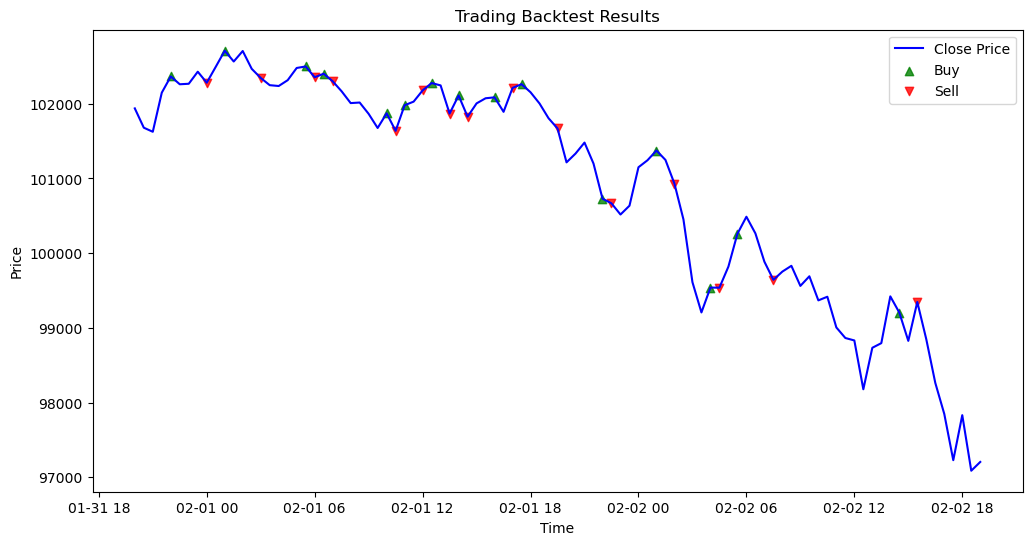

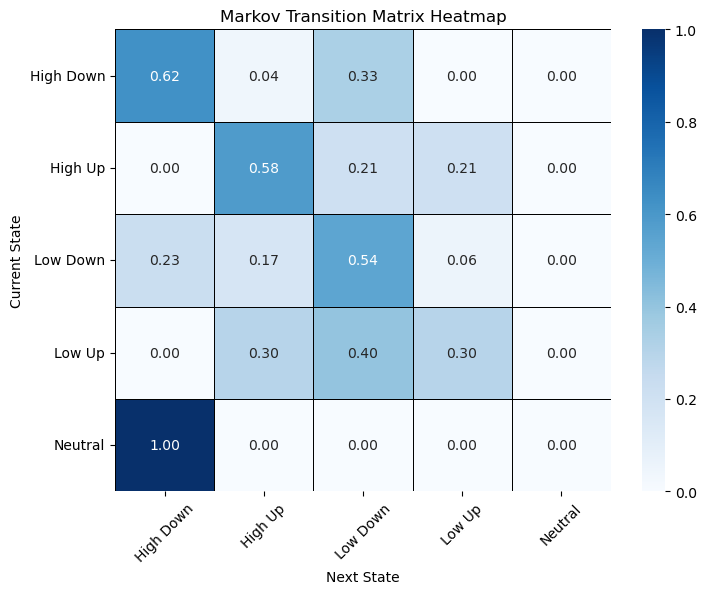

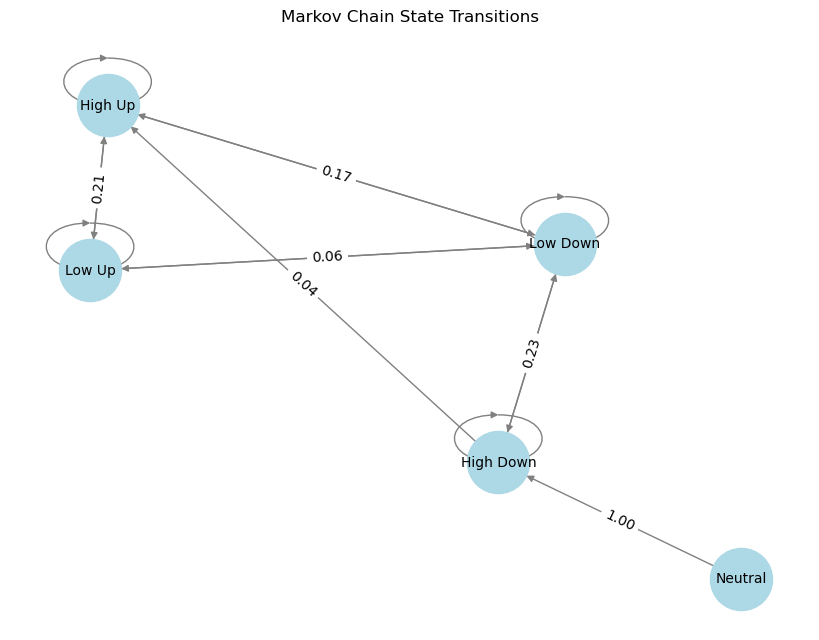

<Figure size 800x400 with 0 Axes>

In [22]:
# Run Analysis
def main():
    df = load_data(PARQUET_PATH)
    if df is None:
        return
    df = compute_velocity(df)
    df = assign_state(df)
    
    transition_matrix = build_transition_matrix(df['state'].values)
    final_balance, trade_history, max_drawdown, total_profit, roi = backtest(df, transition_matrix)

    print(f"Final Balance: {final_balance:.2f} USDT")
    print(f"Total Profit: {total_profit:.2f} USDT")
    print(f"ROI: {roi:.2f}%")
    print(f"Total Trades: {len(trade_history)}")
    
    logging.info(f"Max Drawdown: {max_drawdown:.2%}")
    
    plot_trades(df, trade_history)

    plot_transition_matrix(transition_matrix)

    plot_transition_network(transition_matrix)

main()

## 7️⃣ Running the Full Analysis (`main()`) 

### Concept:
The **`main()`** function serves as the **entry point** for executing the full pipeline, integrating all previously defined functions to:
1. **Load historical market data.**
2. **Compute velocity trends and assign states.**
3. **Build the Markov transition matrix.**
4. **Run backtesting to evaluate trading performance.**
5. **Display key metrics and visualize results.**

### Step-by-Step Execution:
1. **Load Market Data**:
   - Calls `load_data(PARQUET_PATH)` to read the dataset.
   - If the file is missing, the function exits early.

2. **Process the Data**:
   - Computes velocity trends using `compute_velocity(df)`.
   - Assigns market states using `assign_state(df)`.

3. **Build the Transition Matrix**:
   - Calls `build_transition_matrix(df['state'].values)` to generate a **probability-based model** of market transitions.

4. **Run the Backtest Simulation**:
   - Calls `backtest(df, transition_matrix)` to simulate trades based on predicted state transitions.
   - Computes:
     - **Final balance** (total account value after backtesting).
     - **Total profit** earned/lost.
     - **Return on Investment (ROI)** as a percentage.
     - **Max drawdown** to assess risk.

5. **Display Key Performance Metrics**:
   - Prints the final balance, profit, ROI, and number of trades executed.
   - Logs the **Max Drawdown** using `logging.info()` for performance tracking.

6. **Visualize Trading Results**:
   - Calls `plot_trades(df, trade_history)` to generate **price charts with buy/sell markers**.

### Why This Matters:
- **Automates the Full Trading Strategy Simulation**: Combines all functions into a structured workflow.
- **Ensures Proper Data Processing and Evaluation**: Step-by-step execution maintains logical integrity.
- **Provides Immediate Insights**: Key metrics and visualizations help analyze the trading strategy's effectiveness.

---

### Summary:
✅ **`main()`** orchestrates the full analysis from data processing to strategy evaluation.  
✅ Outputs critical **performance metrics** including **profitability and risk assessment**.  
✅ **Final visualization** aids in interpreting trading behavior and refining strategies.  

This function serves as the **core execution unit** for testing and improving the Markov-based trading model. 🚀📊

---

